In [13]:
# Standard library imports
import os
import sys
import re
import itertools
import glob
import pickle
import zipfile

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import geopandas as gpd
import mpmath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
from scipy import stats, optimize as opt, signal
from scipy.special import hyp2f1
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import (
    ScalarFormatter, LogLocator, LogFormatterMathtext, LogFormatter,
    AutoMinorLocator, MultipleLocator, NullFormatter
)
from matplotlib.markers import MarkerStyle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Figure and plotting settings
fig_formats = ['.pdf', '.eps', '.tiff', '.png']
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden * 8 * cms, 8 * cms)
figsizes = {
    "1 column": (3.43, 3.43 / golden),
    "1.5 columns": (4.49, 4.49 / golden),
    "2 columns": (7.01, 7.01 / golden)
}

# Color palettes
light_palette = ['#504B43', '#4caf50', '#948d99']
dark_palette = ['#285DB1', '#AC3127', '#c1bbb0']
color_clusters = ['#648fff', '#ffb000', '#948d99']
paletteTGB = ['#4caf50', '#504B43', '#948d99']
metaTcolor, metaGcolor, metaBcolor = paletteTGB
metacolor = {'metaT': metaTcolor, 'metaG': metaGcolor, 'metaB': metaBcolor}
metamarker = {'metaT': 'o', 'metaG': 'd', 'metaB': 's'}
palettename = 'coolwarm'
palette_temp = sns.color_palette(palettename, 32)

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Seaborn and matplotlib settings
sns.set_theme(
    rc={
        'figure.figsize': figsizes["2 columns"],
        'figure.dpi': 200,
        'savefig.dpi': 300
    },
    font="Helvetica Neue",
    font_scale=1.3,
    style="ticks"
)

plt.rcParams.update({
    'legend.edgecolor': 'k',
    'legend.facecolor': 'w',
    'legend.frameon': True,
    'legend.framealpha': 1,
    'legend.fancybox': False,
    'legend.fontsize': 12,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'k',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 14,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "text.latex.preamble": r"\usepackage{amsmath, helvet} \renewcommand{\familydefault}{\sfdefault}"
})

# Jupyter autoreload magic
%reload_ext autoreload
%autoreload 1

In [2]:
def log_hist(data, nbins=30):    
    data_positive = data[data > 0]
    bins = np.logspace(np.log10(data_positive.min()), np.log10(data_positive.max()), nbins)
    counts = np.histogram(data_positive, bins=bins)[0]
    prob = counts / counts.sum()
    pdf = prob / np.diff(bins)
    return bins, counts, prob, pdf

def return_color_station(station, metadata, palette_temp=palette_temp):
    # if station is a string convert to integer
    if isinstance(station, str):
        station = int(station)
    temperature = int(metadata.loc[station, 'temp_woa'])+1
    return palette_temp[temperature]

def plot_logSAD(data, nbins=20):
    bins, counts, prob, pdf = log_hist(data, nbins=nbins)
    xx = np.sqrt(bins[:-1]*bins[1:])
    yy = pdf
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def plot_logrescaledSAD(data, nbins=20):
    data = data[data>0]
    y = np.log(data)
    z = (y-np.mean(y))/np.std(y)
    hist, bins = np.histogram(z, bins=nbins, density=True)
    xx = (bins[1:] + bins[:-1])/2
    yy = hist
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def paretoDistribution(x, k, a, c, mu):
    if x >= mu:
        pdf = (k**(-1/c) * a * (1 + ((x - mu)/k)**(1/c))**(-1 - a) * (x - mu)**(-1 + 1/c)) / c
    else:
        pdf = 0
    return pdf

In [ ]:
metadata = pd.read_csv('../data/environment/woa_pisces_tarassd.tsv', index_col=0, sep='\t')
metadata.index = metadata.index.astype(int)
metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="ESRI:54030")

metadata['temp_category'] = pd.cut(metadata.temp_woa, bins=[-np.inf, 15, np.inf], labels=['low', 'high'])
metadata['inverseTemperature'] = 1000/(metadata['temp_woa']+273.15)
metadata['color'] = metadata.index.map(lambda x: return_color_station(x, metadata))

In [4]:
metaT = pd.read_csv(f'../data/metaT_micro_bacilla.csv', index_col=0)
metaG = pd.read_csv(f'../data/metaG_micro_bacilla.csv', index_col=0)
metaT.columns = metaT.columns.astype(int)
metaG.columns = metaG.columns.astype(int)
# /Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/data/Abundance.csv
#metaB = pd.read_csv(f'{directory}/metaB_micro/Abundances_C.csv', index_col=0)

df_meta = {'metaT': metaT, 'metaG': metaG}
df_meta_relative = {key: df.div(df.sum(axis=0), axis=1) for key, df in df_meta.items()}

del metaT, metaG


In [5]:
filename = '../fit/summary_fit_metaT_micro_bacilla.csv'
fit_metaT = pd.read_csv(filename, index_col=0)
filename = '../fit/summary_fit_metaG_micro_bacilla.csv'
fit_metaG = pd.read_csv(filename, index_col=0)
#fit_metaT['k_cum_model'] = np.maximum(10**fit_metaT['logk_cum'] - fit_metaT['mu_cum'], fit_metaT['mu_cum'])
fit_metaT['k_KS_model'] = np.maximum(10**fit_metaT['logk'] - fit_metaT['mu_KS'], fit_metaT['mu_KS'])
#fit_metaG['k_cum_model'] = np.maximum(10**fit_metaG['logk_cum'] - fit_metaG['mu_cum'], fit_metaG['mu_cum'])
fit_metaG['k_KS_model'] = np.maximum(10**fit_metaG['logk'] - fit_metaG['mu_KS'], fit_metaG['mu_KS'])

df_fits = {'metaT': fit_metaT, 'metaG': fit_metaG}

for meta in ['metaT', 'metaG']: 
    df_fits[meta]['N_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).sum() for station in df_meta[meta].columns}
    df_fits[meta]['S_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).astype(bool).sum() for station in df_meta[meta].columns}
    df_fits[meta]['mean_n_filtered'] = df_fits[meta]['N_filtered']/df_fits[meta]['S_filtered']
    df_fits[meta]['n_max'] = {station: df_meta[meta][station].max() for station in df_meta[meta].columns}
    df_fits[meta]['fitted_decades'] = np.log10(df_fits[meta]['n_max']) - np.log10(df_fits[meta]['mu_KS'])

In [6]:
gdf = metadata.copy()
gdf['mean_metaT'] = df_meta['metaT'].sum(axis=0)/df_meta['metaT'].astype(bool).sum(axis=0)
gdf['mean_metaG'] = df_meta['metaG'].sum(axis=0)/df_meta['metaG'].astype(bool).sum(axis=0)
gdf['total_metaT'] = df_meta['metaT'].sum(axis=0)
gdf['total_metaG'] = df_meta['metaG'].sum(axis=0)
gdf['mu_metaT'] = df_fits['metaT']['mu_KS']
gdf['mu_metaG'] = df_fits['metaG']['mu_KS']
gdf['alpha_metaT'] = df_fits['metaT']['alpha']
gdf['alpha_metaG'] = df_fits['metaG']['alpha']
gdf['k_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_sup_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk_high'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_sup_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk_high'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_inf_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk_low'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_inf_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk_low'] - row['mu_KS'], row['mu_KS']), axis=1)

gdf['alpha_sup_metaT'] = df_fits['metaT']['alpha_high']
gdf['alpha_sup_metaG'] = df_fits['metaG']['alpha_high']
gdf['alpha_inf_metaT'] = df_fits['metaT']['alpha_low']
gdf['alpha_inf_metaG'] = df_fits['metaG']['alpha_low']

gdf['inverseTemperature'] = 1000/(gdf['temp_woa']+273.15)
gdf['kT/kG'] = gdf['k_metaT']/gdf['k_metaG']

# filter gdf only to stations where k_metaG is non nan
gdf = gdf[gdf['k_metaG'].notna()]

In [7]:
N_metaT = df_meta['metaT'].sum(axis=0)
S_metaT = df_meta['metaT'].fillna(0).astype(bool).sum(axis=0)
N_metaG = df_meta['metaG'].sum(axis=0)
S_metaG = df_meta['metaG'].fillna(0).astype(bool).sum(axis=0)

# Figures S2-S6

In [15]:
figsize=(8.27, 11.69)
labelsize=10
plt.rcParams['text.usetex'] = True

        
for i, station in enumerate(df_meta['metaT'].columns):
    if i % 16 == 0:
        if i < 16*4:
            fig, axes = plt.subplots(8, 4, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.1})
        else:
            fig, axes = plt.subplots(7, 4, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.1})
            # remove the last two axes
            axes[-1, -1].remove()
            axes[-1, -2].remove()

        for i_ax, ax in enumerate(axes.flatten()):
            # set font size of the axes to 12
            ax.tick_params(axis='both', which='major', labelsize=labelsize)
            ax.set_xscale('log')
            ax.set_yscale('log')
            if i_ax % 4 == 0:
                ax.set_ylabel('PDF', fontsize=labelsize)
            if i_ax >= 28:
                ax.set_xlabel('abundance', fontsize=labelsize)
            if i_ax < 4:
                if i_ax % 2 == 0:
                    ax.set_title('metaG', fontsize=labelsize)
                else:
                    ax.set_title('metaT', fontsize=labelsize)
            ax.grid(True, lw=0.35, ls='--', alpha=0.5)
            
            # ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
            # ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
            
            ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[], numticks=10))  # No minor ticks
            ax.xaxis.set_minor_formatter(NullFormatter())   

            # Customize grid
            ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
            ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
            ax.xaxis.set_major_formatter(LogFormatterMathtext())
            ax.yaxis.set_major_formatter(LogFormatterMathtext())
            
    for meta in ['metaT', 'metaG']:
        df = df_meta[meta]
        data = df[station]
        fit = df_fits[meta].loc[station]
        k, alpha, gamma, mu = 10**fit['logk'], fit['alpha'], 1, fit['mu_KS']
        data = data[~data.isna()]
        data = data[data>=mu]
        x, y = plot_logSAD(data, nbins=20)
        if meta == 'metaT':
            ax = axes.flatten()[(2*i)%32+1]
        else:
            ax = axes.flatten()[(2*i)%32]
        sns.lineplot(x=x, y=y, ax=ax, color=metacolor[meta], lw=0.3, marker=metamarker[meta], markersize=4.5, markeredgecolor='k')

        xlim_inf, xlim_sup = 10**np.floor(np.log10(data.min())), 10**np.ceil(np.log10(data.max()))
        ax.set_xlim(xlim_inf, xlim_sup)
        xticks = 10**np.arange(np.floor(np.log10(data.min())), np.ceil(np.log10(data.max()))+1, 1)
        ax.set_xticks(xticks)
        # remove minor xticks
        ylim_inf, ylim_sup = 10**np.floor(np.log10(y.min())), 10**np.ceil(np.log10(y.max()))
        ax.set_ylim(ylim_inf, ylim_sup)
        # if there are more than 5 decades, set the yticks every 2 decades
        if np.ceil(np.log10(y.max())) - np.floor(np.log10(y.min())) > 5:
            yticks = 10**np.arange(np.floor(np.log10(y.min())), np.ceil(np.log10(y.max()))+1, 2)
        else:
            yticks = 10**np.arange(np.floor(np.log10(y.min())), np.ceil(np.log10(y.max()))+1, 1)
        ax.set_yticks(yticks)
        
        
        x_plot = np.logspace(np.log10(1.00001*data.min()), np.log10(data.max()), 100)
        y_plot = [paretoDistribution(xx, k, alpha, gamma, mu) for xx in x_plot]
        sns.lineplot(x=x_plot, y=y_plot, ax=ax, color=metacolor[meta], lw=3.3, ls='--', zorder=0)
        text = 'station: ' + str(station)
        ax.text(0.95, 0.95, text, transform=ax.transAxes, ha='right', va='top', size=labelsize)
        #ax.set_title(station, fontsize=labelsize)
        
        pvalue_KS = fit['p_KS']
        pvalue_AD = fit['p_AD']
        if pvalue_KS >= 0.01:
            text = r"$p_K$ = {0:1.2f}".format(pvalue_KS)
        else:
            text = r"$p_K$ < 0.01"
        text += '\n'
        if pvalue_AD >= 0.01:
            text += r"$p_A$ = {0:1.2f}".format(pvalue_AD)
        else:  
            text += r"$p_A$ < 0.01"
        ax.text(0.05, 0.05, text, transform=ax.transAxes, ha='left', va='bottom', size=labelsize-2) 
        
        
        axg = ax.inset_axes([0.5, 0.45, 0.48, 0.4], zorder=-10)
        gpd.plotting.plot_dataframe(world, ax=axg, color='white', edgecolor='#d6d6d6', alpha=1., lw=.75)
        axg.scatter(metadata.loc[station, 'longitude'], metadata.loc[station, 'latitude'], marker='+', color='black', s=150, zorder=10)
        #title = r'#{0}: ({1:1.1f},{2:1.1f})'.format(station, metadata.loc[station, 'latitude'], metadata.loc[station, 'longitude'])
        #axg.set_title(title, fontsize=9)
        axg.set_axis_off()
        
    if i == len(df_meta['metaT'].columns)-1:
        # remove empty axes
        # for i_ax in range(i_ax+1, 32):
        #     fig.delaxes(axes.flatten()[i_ax])
        figname = 'figures/SM/SADs_all_{}.png'.format(i//16+1)
        os.makedirs('figures/SM/', exist_ok=True)
        fig.savefig(figname, dpi=300, bbox_inches='tight')
        plt.close(fig)
        
    if i % 16 == 15:
        figname = 'figures/SM/SADs_all_{}.png'.format(i//16+1)
        os.makedirs('figures/SM/', exist_ok=True)
        fig.savefig(figname, dpi=300, bbox_inches='tight')
        plt.close(fig)

# Figure S7

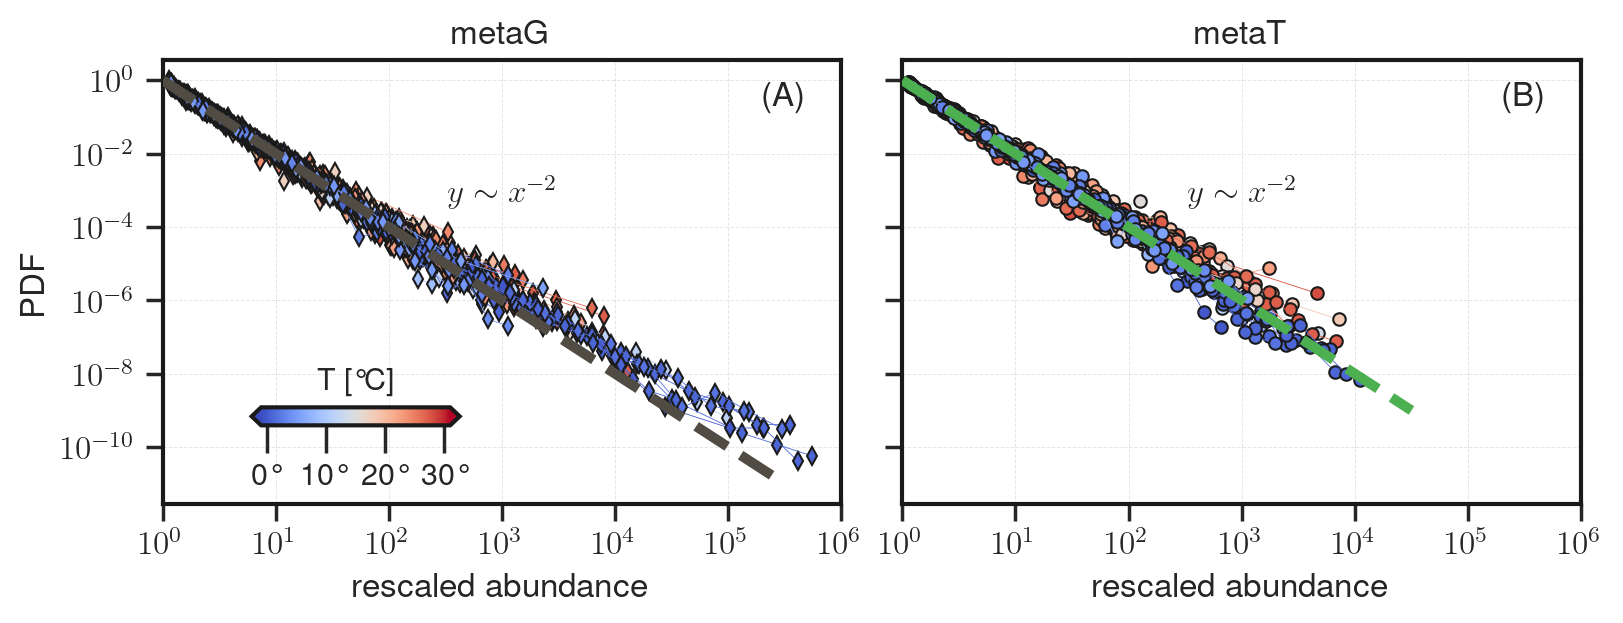

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True, gridspec_kw={'hspace': 0.5}, sharey=True)
labelsize=12

for i_ax, ax in enumerate(axes.flatten()):
    # set font size of the axes to 12
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i_ax % 4 == 0:
        ax.set_ylabel('PDF', fontsize=labelsize)
    if i_ax >= 0:
        ax.set_xlabel('rescaled abundance', fontsize=labelsize)
    if i_ax < 4:
        if i_ax % 2 == 0:
            ax.set_title('metaG', fontsize=labelsize)
            text = '(A)'
            ax.text(0.95, 0.95, text, transform=ax.transAxes, ha='right', va='top', fontsize=12)
            
            cax = fig.add_axes([0.15, 0.31, 0.13, 0.03])
            cax.tick_params(labelsize=10, size=10)
            sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
            sm._A = []
            cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal', extend='both')#, fraction=0.026, pad=-0.2)
            cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
            cbar.ax.set_title('T [°C]', font='Avenir', fontsize=11)
        else:
            ax.set_title('metaT', fontsize=labelsize)
            text = '(B)'
            ax.text(0.95, 0.95, text, transform=ax.transAxes, ha='right', va='top', fontsize=12)
    ax.grid(True, lw=0.35, ls='--', alpha=0.5)
    ax.set_xlim(1e0, 1e6)
    
    # ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
    # ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
    
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[], numticks=10))  # No minor ticks
    #ax.xaxis.set_minor_formatter(NullFormatter())   

    # Customize grid
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.xaxis.set_major_formatter(LogFormatterMathtext())
    ax.yaxis.set_major_formatter(LogFormatterMathtext())
    
    text = r'$y \sim x^{-%.0f}$' % (alpha+1)
    ax.text(0.5, 0.7, text, transform=ax.transAxes, ha='center', va='center', fontsize=12)
    
    


        
for i, station in enumerate(df_meta['metaT'].sample(frac=1, random_state=42).columns):

    for meta in ['metaT', 'metaG']:
        df = df_meta[meta]
        data = df[station]
        fit = df_fits[meta].loc[station]
        k, alpha, gamma, mu = 10**fit['logk'], fit['alpha'], 1, fit['mu_KS']
        data = data[~data.isna()]
        data = data[data >= mu]
        color = return_color_station(station, metadata, palette_temp=palette_temp)

        data_rescaled = ((data + k - mu) / k) ** alpha

        x, y = plot_logSAD(data_rescaled, nbins=20)
        if meta == 'metaT':
            ax = axes[1]
        else:
            ax = axes[0]
            
            
        sns.lineplot(x=x, y=y, ax=ax, color=color, lw=0.3, marker=metamarker[meta], markersize=4.5, markeredgecolor='k')
        
        if i == 0:     
            if meta=='metaT':
                xplot = np.logspace(0, 4.5, 100)
            else:
                xplot = np.logspace(0, 5.5, 100)
            yplot = 1*xplot**(-2)
            sns.lineplot(x=xplot, y=yplot, ax=ax, color=metacolor[meta], lw=3.6, ls='--', zorder=10)

# figname = 'figures/thesis/SADs_rescaled_all.png'
# os.makedirs('figures/thesis/', exist_ok=True)
# fig.savefig(figname, dpi=300, bbox_inches='tight')

# Figure S8

mean = 52.696252344332095, meanlog = 46.82858757963229
error on the mean = 3.326572309020192
slope = 0.4772903697434817, intercept = 2.1988480761913296, r_value = 0.1246683625875898, p_value = 0.28001380119342667, std_err = 0.4386259649163364


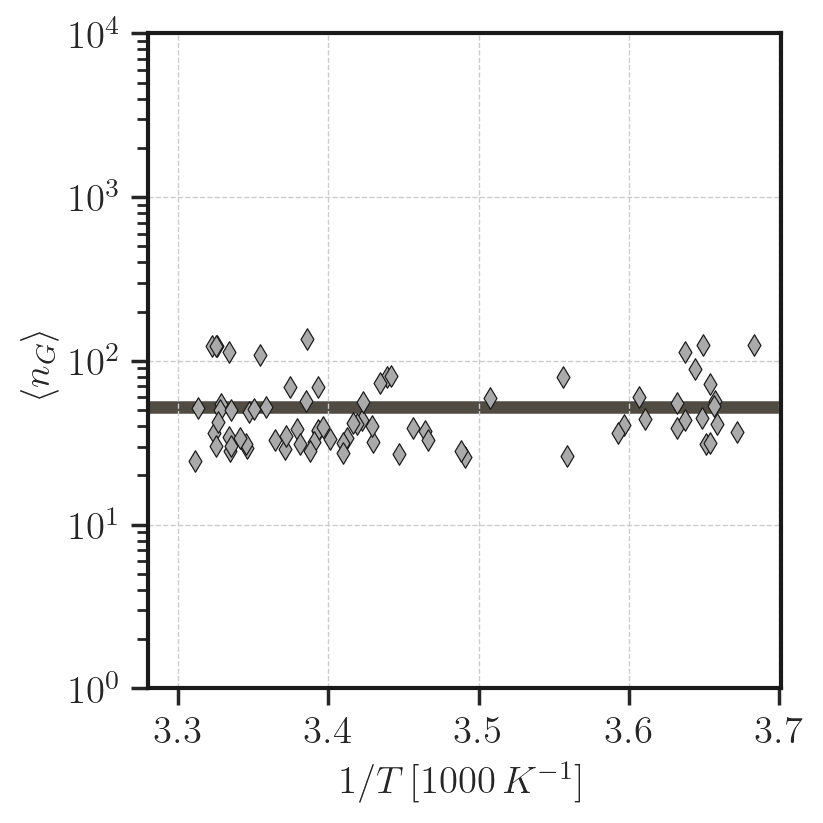

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

# Customize grid
#ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(LogFormatterMathtext())


ax.set_yscale('log')
ax.set_ylim(1e-2, 1e3)
ax.set_xticks(np.arange(3.3, 3.8, 0.1))
ax.set_xlim(3.28, 3.701)
ax.set_xlabel(r'$1/T\, [1000\, K^{-1}]$' )
ax.set_ylabel(r'$t_0(T)/\gamma_1(T)$ fit' )


y = df_meta['metaG'].fillna(0).sum(axis=0)/df_meta['metaG'].fillna(0).astype(bool).sum(axis=0)
x = metadata.loc[y.index, 'inverseTemperature']
ymean = y.mean()
ymeanlog = np.exp(np.mean(np.log(y)))
print(f'mean = {ymean}, meanlog = {ymeanlog}')
# error on the mean
std = y.std()
error_mean = std/np.sqrt(len(y))
print(f'error on the mean = {error_mean}')

logy = np.log(y)
slope, intercept, r_value, p_value, std_err = linregress(x, logy)
print(f'slope = {slope}, intercept = {intercept}, r_value = {r_value}, p_value = {p_value}, std_err = {std_err}')

ax.axhline(ymean, color=metaGcolor, lw=4.5, ls='-', zorder=0)
#ax.axhline(ymean+2*std, color=metaGcolor, lw=1.5, ls='--', zorder=0)
#ax.axhline(ymean-1.*std, color=metaGcolor, lw=1.5, ls='--', zorder=0)

sns.scatterplot(x=x, y=y, ax=ax, color='#AAAAAA', edgecolor='k', s=30, marker='d')

ax.set_ylabel(r'$\langle n_{G} \rangle$')

ax.set_ylim(1e0, 1e4)
ax.grid(True, which='major', linestyle='--', lw=0.5)

#ax.legend()

figname = 'figures/SM/mean_n_metaG.png'
os.makedirs(os.path.dirname(figname), exist_ok=True)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Figure S9

slopeT = 10.853660071590225, interceptT = -29.96485066150649, r_valueT = 0.7505763193185726, p_valueT = 3.870347800301439e-15, std_errT = 1.1033418520770595
interceptT = 9.69238611231312e-14, std_intercept = 3.6200194382433324
2.5958299580134256e-15 3.618971584026783e-12
Energies for metaT: 0.94+-0.10 eV
energy_richness = 0.94 eV, richness_S0 = 9.69e-14+-1.39e-13


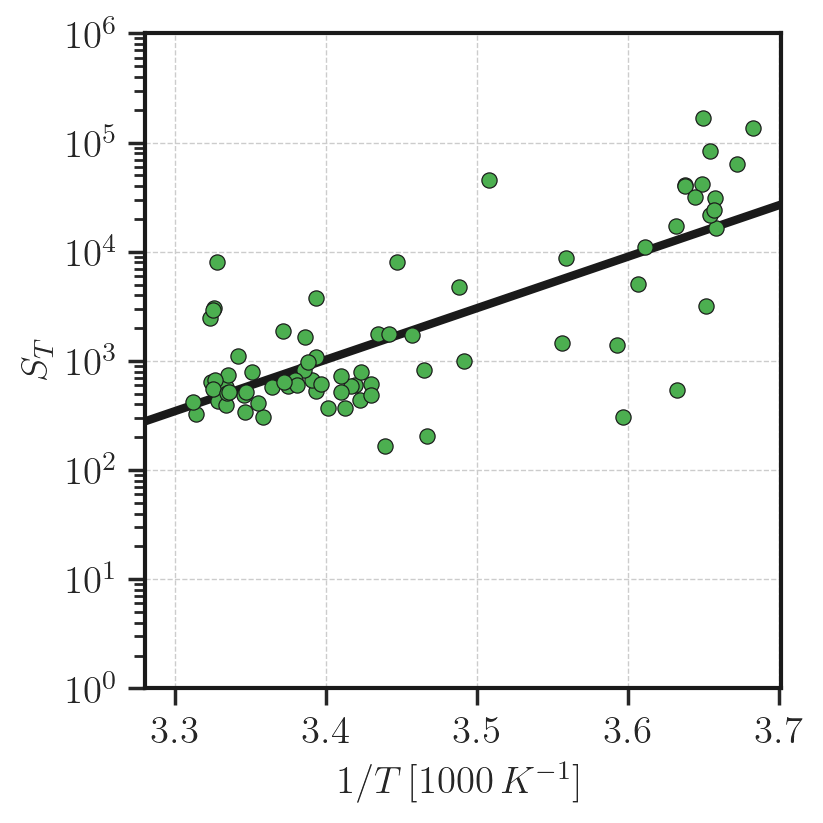

In [15]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

ax.set_yscale('log')
ax.set_ylim(1e0, 1e6)
ax.set_xticks(np.arange(3.3, 3.8, 0.1))
ax.set_xlim(3.28, 3.701)
ax.set_xlabel(r'$1/T\, [1000\, K^{-1}]$' )
ax.set_ylabel(r'$S_{T}$')
ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.grid(True, which='major', linestyle='--', lw=0.5)
# Customize grid
#ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(LogFormatterMathtext())



x = metadata['inverseTemperature']
yT = df_meta['metaT'].fillna(0).astype(bool).sum(axis=0)
# select only the temperatures for which we have data for both metaT and metaG
x = x.loc[yT.index]

sns.scatterplot(x=x, y=yT, ax=ax, color=metaTcolor, edgecolor='k', s=30, zorder=2)

logyT = np.log(yT)
slopeT, interceptT, r_valueT, p_valueT, std_errT = stats.linregress(x, logyT)
print(f'slopeT = {slopeT}, interceptT = {interceptT}, r_valueT = {r_valueT}, p_valueT = {p_valueT}, std_errT = {std_errT}')

xmean = np.mean(x)
std_intercept = std_errT * np.sqrt(1/len(x) + xmean**2/np.sum((x-xmean)**2))
print(f'interceptT = {np.exp(interceptT)}, std_intercept = {std_intercept}')
print(np.exp(interceptT-std_intercept), np.exp(interceptT+std_intercept))


x_plot = np.linspace(3.28, 3.701, 100)
y_plot = np.exp(slopeT*x_plot+interceptT)
sns.lineplot(x=x_plot, y=y_plot, ax=ax, color='k', ls='-', zorder=1, lw=3)

K_boltmann = 8.617333262145e-5 # in eV/K
ET = slopeT*K_boltmann*1e3
sigma_ET = std_errT*K_boltmann*1e3
n = len(x)
x_mean = np.mean(x)
std_err_intercept = std_err * np.sqrt(np.sum(x**2) / (n * np.sum((x - x_mean)**2)))
print(f'Energies for metaT: {ET:1.2f}+-{sigma_ET:1.2f} eV')

energy_richness = ET
sigma_energy_richness = sigma_ET
richness_S0 = np.exp(interceptT)
sigma_richness_S0 = std_err_intercept * richness_S0
print(f'energy_richness = {energy_richness:1.2f} eV, richness_S0 = {richness_S0:1.2e}+-{sigma_richness_S0:1.2e}')

figname = 'figures/SM/S_ifo_T_mT.png'
os.makedirs(os.path.dirname(figname), exist_ok=True)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Heaps scaling theory

In [16]:
# input
S_metaT = df_meta['metaT'].fillna(0).astype(bool).sum(axis=0)
N_metaT = df_meta['metaT'].fillna(0).sum(axis=0)
colors = metadata.loc[S_metaT.index, 'color']

# data
N_metaG = df_meta['metaG'].fillna(0).sum(axis=0)
S_metaG = df_meta['metaG'].fillna(0).astype(bool).sum(axis=0)
k_metaT = df_fits['metaT']['k_KS_model']
k_metaG = df_fits['metaG']['k_KS_model']

## Temperature sensitivity of transcription efficiency

In [17]:
x = gdf['inverseTemperature']
y = gdf['kT/kG'] # transcription efficiency
x = x[y > 0]
y = y[y > 0]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))
K_boltzmann = 8.617333262145e-5 # in eV/K
E = slope * K_boltzmann * 1e3
sigma_E = std_err * K_boltzmann * 1e3

sensitivity_transcription_efficiency = E
sigma_sensitivity_transcription_efficiency = sigma_E

n = len(x)
x_mean = np.mean(x)
std_err_intercept = std_err * np.sqrt(1/n + x_mean**2/np.sum((x - x_mean)**2))
r_over_gamma_inf = np.exp(intercept)
std_upper_r_over_gamma_inf = np.exp(intercept + std_err_intercept) # the normality assumption is not valid here, so we use the exponential of the intercept plus the standard error
std_lower_r_over_gamma_inf = np.exp(intercept - std_err_intercept)


print(f"Temperature sensitivity of transcription efficiency: {E:1.2f}±{sigma_E:1.2f} eV. p-value={p_value:1.4f}")
print(f"r/gamma_inf: {r_over_gamma_inf:1.2e}. C.I.: upper: {std_upper_r_over_gamma_inf:1.2e} lower: {std_lower_r_over_gamma_inf:1.2e} (n={n})")


Temperature sensitivity of transcription efficiency: 0.34±0.11 eV. p-value=0.0038
r/gamma_inf: 3.79e-06. C.I.: upper: 2.95e-04 lower: 4.87e-08 (n=77)


## Temperature sensitivity of transcription richness

In [18]:
x = gdf['inverseTemperature']
y = df_meta['metaT'].fillna(0).astype(bool).sum(axis=0) # transcription richness
x = x[y > 0]
y = y[y > 0]

logy = np.log(y)
slopeT, interceptT, r_valueT, p_valueT, std_errT = stats.linregress(x, logy)

K_boltzmann = 8.617333262145e-5 # in eV/K
epsilon = slopeT*K_boltzmann*1e3
sigma_epsilon = std_errT*K_boltzmann*1e3

sensitivity_transcription_richness = epsilon
sigma_sensitivity_transcription_richness = sigma_epsilon

n = len(x)
x_mean = np.mean(x)
std_err_intercept = std_err * np.sqrt(np.sum(x**2) / (n * np.sum((x - x_mean)**2)))
S_inf = np.exp(interceptT)
std_upper_S_inf = np.exp(interceptT + std_err_intercept)  # the normality assumption is not valid here, so we use the exponential of the intercept plus the standard error
std_lower_S_inf = np.exp(interceptT - std_err_intercept)

print(f"Temperature sensitivity of transcription richness: {epsilon:1.2f}±{sigma_epsilon:1.2f} eV. p-value={p_valueT:1.4f}")
print(f"S_inf: {S_inf:1.2e}. C.I.: upper: {std_upper_S_inf:1.2e} lower: {std_lower_S_inf:1.2e} (n={n})")

Temperature sensitivity of transcription richness: 0.94±0.10 eV. p-value=0.0000
S_inf: 9.69e-14. C.I.: upper: 7.54e-12 lower: 1.25e-15 (n=77)


## Heaps prediction

In [19]:
K_inv = (N_metaG/S_metaG).mean() * r_over_gamma_inf * S_inf**(-E/epsilon)
eta = 1+E/epsilon
sigma_eta = np.sqrt((1+1/energy_richness)**2 * sigma_E**2 + (1-sigma_E/epsilon**2)**2 * sigma_epsilon**2)

xi = 1/eta
sigma_xi = sigma_eta/eta**2
print(f'xi : {xi:1.2f}±{sigma_xi:1.2f}')

xi : 0.73±0.13


fitted xi: 0.73±0.03
predicted xi: 0.73±0.13


<Axes: xlabel='$N$', ylabel='$S$'>

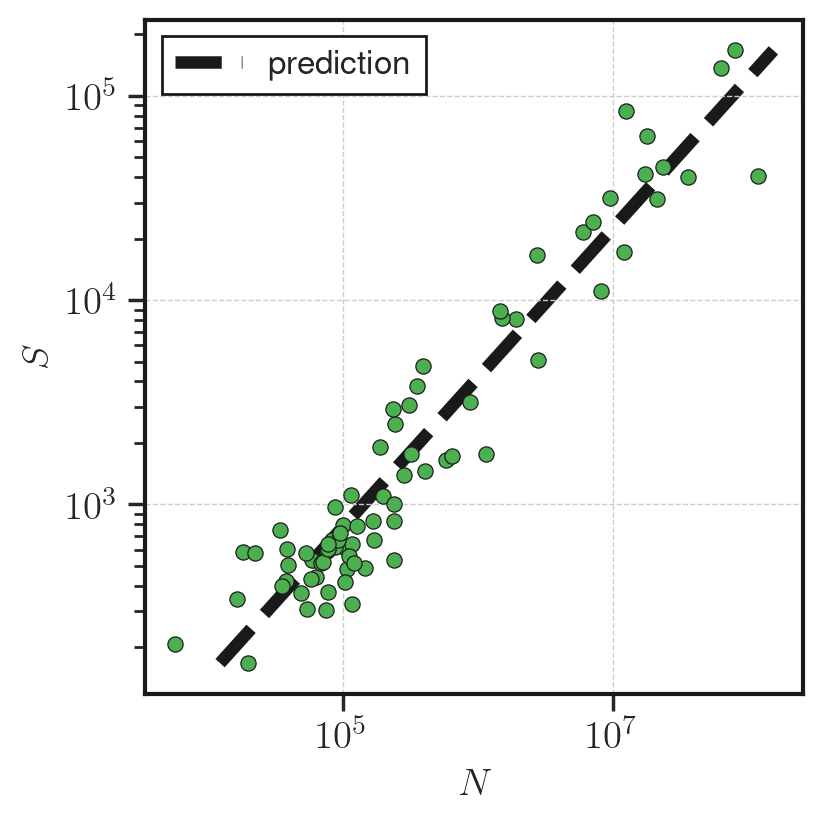

In [20]:
N_metaT_pred = (N_metaG/S_metaG).mean() * S_metaT**(1+E/epsilon) * r_over_gamma_inf * S_inf**(-E/epsilon)
N_metaT = df_meta['metaT'].fillna(0).sum(axis=0)

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.grid(True, which='major', linestyle='--', lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$S$')

sns.scatterplot(y=S_metaT, x=N_metaT, ax=ax, color=metaTcolor, edgecolor='k', s=30, marker='o')

logy = np.log10(S_metaT)
logx = np.log10(N_metaT)
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
# print(f'slope = {slope}, intercept = {intercept}, r_value = {r_value}, p_value = {p_value}, std_err = {std_err}')
print(f"fitted xi: {slope:1.2f}±{std_err:1.2f}")
print(f"predicted xi: {xi:1.2f}±{sigma_xi:1.2f}")

label = 'prediction'
x_plot = np.logspace(np.log10(N_metaT_pred.min()), np.log10(N_metaT_pred.max()), 100)
y_plot = (x_plot/K_inv)**(1/eta)
sns.lineplot(x=x_plot, y=y_plot, ax=ax, color='k', ls='--', zorder=0, lw=4.5, label=label)